In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

from fbprophet import Prophet
# from fbprophet.utilities import regressor_coefficients

In [2]:
df = pd.read_csv('./data/rent_airbnb_all_features.csv')
print(df.shape)
df.head()

(1752, 37)


,year,quarter,district_code,district_name,neighbourhood_code,neighbourhood_name,price_month(€),price_m2_month(€),From 6 months to 12 motnhs,Over 12 months,...,woman_junior_high_school,woman_senior_high_school,woman_unknown,woman_without education,airbnb_price(€),n_airbnb_listings,availability_365,airbnb_ratio_business,airbnb_professional_ratio,airbnb_mega_host_ratio
0,2015.0,2015-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",697.16,11.51,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015.0,2015-04-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",708.03,12.02,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,73.343300,903.0,262.921373,0.631229,0.128461,0.016611
2,2015.0,2015-07-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",729.00,14.00,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,75.124776,1114.0,259.641831,0.607720,0.106822,0.002693
3,2015.0,2015-10-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",751.60,13.43,2949.0,8425.0,...,1464.0,2067.0,5.0,470.0,72.410441,1111.0,271.629163,0.580558,0.067507,0.001800
4,2016.0,2016-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",759.16,12.94,2563.0,7550.0,...,1509.0,2196.0,121.0,376.0,72.739919,992.0,260.639113,0.561492,0.073589,0.000000


## First, simplify columns

In [3]:
def sum_columns_and_drop(df, columns, new_column, position):
    # convert the list of column names into a numeric range
    cols_range = []
    for col in columns:
        index_no = df.columns.get_loc(col)
        cols_range.append(index_no)
    cols_range = np.array(cols_range)
    
    # insert the new colum with the sum of all given columns
    df.insert(position, new_column, df.iloc[:, cols_range].sum(axis=1))
    # drop the old columns and return the dataframe
    return df.drop(columns=columns)


In [4]:
df = sum_columns_and_drop(df, ['2 Spanish', '3 Spanish', '4 espanyols o més'], 'more than 2 Spanish', 13)
df = sum_columns_and_drop(df, ['2 foreigners', '3 foreigners', 'more than 4 foreigners'], 'more than 2 foreigners', 13)
df = sum_columns_and_drop(df, ['Up to 6 months', 'From 6 months to 12 motnhs'], 'short-term unemployment', 9)
df = df.rename(columns={'Over 12 months':'long-term unemployment'})
df = sum_columns_and_drop(df, ['man_without education', 'woman_without education', 'woman_unknown', 'man_unknown'], 'no education', 14)
df = sum_columns_and_drop(df, ['man_elementary_school', 'man_junior_high_school', 'man_senior_high_school',
                               'woman_elementary_school', 'woman_junior_high_school', 'woman_senior_high_school'], 'medium education', 15)
df = sum_columns_and_drop(df, ['man_bachelors_degree', 'woman_bachelors_degree'], 'bachelors degree', 16)


In [5]:
print(df.shape)
df.head()

(1752, 23)


,year,quarter,district_code,district_name,neighbourhood_code,neighbourhood_name,price_month(€),price_m2_month(€),short-term unemployment,long-term unemployment,...,more than 2 Spanish,no education,medium education,bachelors degree,airbnb_price(€),n_airbnb_listings,availability_365,airbnb_ratio_business,airbnb_professional_ratio,airbnb_mega_host_ratio
0,2015.0,2015-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",697.16,11.51,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015.0,2015-04-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",708.03,12.02,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,73.343300,903.0,262.921373,0.631229,0.128461,0.016611
2,2015.0,2015-07-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",729.00,14.00,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,75.124776,1114.0,259.641831,0.607720,0.106822,0.002693
3,2015.0,2015-10-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",751.60,13.43,11574.0,8425.0,...,3572.0,667.0,11846.0,7482.0,72.410441,1111.0,271.629163,0.580558,0.067507,0.001800
4,2016.0,2016-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",759.16,12.94,10754.0,7550.0,...,3534.0,752.0,11759.0,7573.0,72.739919,992.0,260.639113,0.561492,0.073589,0.000000


In [6]:
# rename 'quarter' as 'ds' and 'price_month(€)' as 'y', to use the fbprophet library
df = df.rename(columns={'quarter':'ds', 'price_month(€)':'y'})

In [7]:
# convert the 'ds' column to datetime objects
df['ds'] = df['ds'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')).values

In [8]:
# I'll make the imputation at the neighbourhood level
df.isna().sum()

year                           0
ds                             0
district_code                  0
district_name                  0
neighbourhood_code             0
neighbourhood_name             0
y                            118
price_m2_month(€)            119
short-term unemployment        0
long-term unemployment         0
1 Spanish                      0
1 foreigner                    0
more than 2 foreigners         0
more than 2 Spanish            0
no education                   0
medium education               0
bachelors degree               0
airbnb_price(€)              219
n_airbnb_listings            219
availability_365             219
airbnb_ratio_business        219
airbnb_professional_ratio    219
airbnb_mega_host_ratio       219
dtype: int64

In [9]:
# import the population dataset
pop_df = pd.read_csv('./data/cleaned/population/population.csv')
print(pop_df.shape)
pop_df.head()

(439, 6)


,year,district_code,district_name,neighbourhood_code,neighbourhood_name,population
0,2015,9,Sant Andreu,58,Baró de Viver,2482
1,2015,7,Horta-Guinardó,34,Can Baró,8938
2,2015,8,Nou Barris,47,Can Peguera,2267
3,2015,8,Nou Barris,49,Canyelles,6946
4,2015,8,Nou Barris,55,Ciutat Meridiana,10156


In [10]:
# merge the original dataframe with the population dataset
df = df.merge(pop_df[['year', 'neighbourhood_name', 'population']], on=('neighbourhood_name', 'year'), how='left')
df.head()

,year,ds,district_code,district_name,neighbourhood_code,neighbourhood_name,y,price_m2_month(€),short-term unemployment,long-term unemployment,...,no education,medium education,bachelors degree,airbnb_price(€),n_airbnb_listings,availability_365,airbnb_ratio_business,airbnb_professional_ratio,airbnb_mega_host_ratio,population
0,2015.0,2015-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",697.16,11.51,11574.0,8425.0,...,667.0,11846.0,7482.0,NaN,NaN,NaN,NaN,NaN,NaN,22305
1,2015.0,2015-04-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",708.03,12.02,11574.0,8425.0,...,667.0,11846.0,7482.0,73.343300,903.0,262.921373,0.631229,0.128461,0.016611,22305
2,2015.0,2015-07-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",729.00,14.00,11574.0,8425.0,...,667.0,11846.0,7482.0,75.124776,1114.0,259.641831,0.607720,0.106822,0.002693,22305
3,2015.0,2015-10-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",751.60,13.43,11574.0,8425.0,...,667.0,11846.0,7482.0,72.410441,1111.0,271.629163,0.580558,0.067507,0.001800,22305
4,2016.0,2016-01-01,1.0,Ciutat Vella,4.0,"Sant Pere, Santa Caterina i la Ribera",759.16,12.94,10754.0,7550.0,...,752.0,11759.0,7573.0,72.739919,992.0,260.639113,0.561492,0.073589,0.000000,22380


In [11]:
# normalize the population variables
# population_features = ['short-term unemployment', 'long-term unemployment','1 Spanish', '1 foreigner',
#                        'more than 2 foreigners', 'more than 2 Spanish', 'no education', 
#                        'medium education', 'bachelors degree']

# def norm_pop(row):
#     return row[population_features] / row['population']
    
# df[population_features] = df.apply(norm_pop, axis=1)
# df.head()

In [12]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [13]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
from neuralprophet import NeuralProphet

def plot_prediction_prophet(neighbourhood_name, df_neighb, forecast, features, vline_x='', model_type='prophet'):
    if model_type == 'prophet':
        forecast_var = 'yhat'
        title = f'Prediction of price/month for the neighbourhood of {neighbourhood_name} - Prophet'
    elif model_type == 'neural_prophet':
        forecast_var = 'yhat1'
        title = f'Evolution of price/month for the neighbourhood of {neighbourhood_name} - NeuralProphet'

    if len(features):
        title += '- added regressors'
    # plot real data and prediction
    fig = plt.figure(figsize=(12,8))
    
    plt.plot(df_neighb['ds'], df_neighb['y'], label='real', zorder=1)
    plt.plot(forecast['ds'], forecast[forecast_var], label='predicted', zorder=0)

    # if model_type is prophet, add confidence intervals
    if model_type == 'prophet':
        plt.plot(forecast['ds'], forecast['yhat_lower'], "r--", label='confidence interval', alpha=0.5)
        plt.plot(forecast['ds'], forecast['yhat_upper'], "r--", alpha=0.5)

    # make a vertical line to separate train_df from test_df
    if vline_x != '':
        ymin = (forecast[forecast_var].min() if forecast[forecast_var].min() < df_neighb['y'].min() else df_neighb['y'].min()) * (1 - 0.01)
        ymax = (forecast[forecast_var].max() if forecast[forecast_var].max() > df_neighb['y'].max() else df_neighb['y'].max()) * (1 + 0.01)
    
        plt.vlines(vline_x, ymin=ymin, ymax=ymax, colors='grey', linestyles='dashed', label='train/test')
    
    plt.xticks(ticks=forecast['ds'])
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()


def predict_prophet(df, model, features=[], n_periods=4, freq='QS'):
    future = model.make_future_dataframe(periods=n_periods, freq=freq)

    for i, feat in enumerate(features):
        future[feat] = df[feat].values
    
    forecast = model.predict(future)
    return forecast


def predict_neural_prophet(df, model, future_regressors_df, n_periods=4):
    future = model.make_future_dataframe(df, regressors_df=future_regressors_df, periods=n_periods)

    forecast = model.predict(future)
    
    forecast = pd.concat([df.rename(columns={'y':'yhat1'}), forecast], axis=0).reset_index(drop=True)
    
    return forecast

    
def fit_prophet(df_train, features=[]):
    model = Prophet(yearly_seasonality=True, n_changepoints=2)

    print('\nAdded regressors:')
    for i, feat in enumerate(features):
        print(f'    -{feat}')
        model.add_regressor(feat)
    model.fit(df_train)
    return model
 
    
def fit_neural_prophet(df, features=[], freq='QS'):
    #model = NeuralProphet(n_changepoints=2, yearly_seasonality=True)
    model = NeuralProphet()
    
    print('\nAdded regressors:')
    for feat in features:
        print(f'    -{feat}')
        model = model.add_future_regressor(name=feat)

    model.fit(df, freq=freq)
    return model
 
    
def scale_features(X):
    scaler = MinMaxScaler(feature_range=(0, 1))    
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
    return X_scaled


def most_corr_features(df):
    features = df.corr()['y'].abs().sort_values(ascending=False).drop('y', axis=0).keys().to_list()
    return features


def imput_missing_values(X):
    imputer = KNNImputer(n_neighbors=2)
    #imputer = IterativeImputer(random_state=42)
    imputer.fit(X[X.notna().all(axis=1)])

    X = pd.DataFrame(imputer.transform(X), index=X.index, columns=X.columns)
    return X


def predict_rent_prophet(neighbourhood_name, n_features=0, model_type='prophet', how='test', test_size=0.25, n_periods=4, freq='QS', scale=False, verbose=False):
    print(f'\n------- Predicting forecast for rental prices for the {neighbourhood_name} neighbourhood -------')
    # 1. select the given neighbourhood
    df_neighb = df[df['neighbourhood_name'] == neighbourhood_name]
    
    # -------- Printings ------
    if verbose:
        print('\nNeighbourhood dataframe:')
        print(df_neighb.head())
    # -------------------------
  
    # 2. Treat NaN values with KNNImputer
    X = df_neighb.drop(columns=['ds', 'district_name', 'neighbourhood_name'], axis=1)
    df_neighb = imput_missing_values(X).assign(ds=df_neighb['ds'].values, 
                                               district_name=df_neighb['district_name'].values, 
                                               neighbourhood_name=df_neighb['neighbourhood_name'].values)
 
    # -------- Printings ------
    if verbose:
        print('\nNaNs:')
        print(df_neighb.isna().sum())
    # -------------------------
    
    features = []
    if how == 'test':
        # 3. order the features by correlation with our target 'y'
        features = most_corr_features(df_neighb.drop(['year', 'neighbourhood_code', 'neighbourhood_name',
                                                  'price_m2_month(€)', 'district_code', 'district_name'], axis=1))

        # -------- Printings ------
        if verbose:
            print(f'\nAll features, ordered from most correlated to less: {features}')
        # -------------------------
    
        # 4. scale the features
        if scale:
            X_scaled = scale_features(df_neighb[features])
            X_scaled['ds'] = df_neighb['ds'].values
            X_scaled['y'] = df_neighb['y'].values
    
            df_neighb = X_scaled

        # -------- Printings ------
        if verbose:
            print('\nAfter scaling:')
            print(df_neighb.head())
        # -------------------------
              
        # 5. reserve 30% of data for testing
        df_train, df_test, df_train, df_test = timeseries_train_test_split(df_neighb, df_neighb, test_size=test_size)

        # -------- Printings ------
        if verbose:
            print('\nLenght of train and test sets:')
            print(f'train: {df_train.shape[0]}')
            print(f'test: {df_test.shape[0]}')
        # -------------------------
    elif how == 'future':
        df_train = df_neighb
        
    # 5b. To use neuralprophet, the dataset has only ds and y
    if model_type == 'neural_prophet':
        df_train = df_train[['ds', 'y'] + features[:n_features]]

    # -------- Printings ------
    if verbose:
        print('\nTrain dataframe:')
        print(f'{df_train}')
    # -------------------------
    
    # 6. fit the model
    if model_type == 'prophet':
        model = fit_prophet(df_train, features=features[:n_features])
    elif model_type == 'neural_prophet':
        model = fit_neural_prophet(df_train, features=features[:n_features], freq=freq)
    
    # 7. predict
    forecast = pd.DataFrame()
    if how == 'test':
        n_periods = df_test.shape[0]
            
    if model_type == 'prophet':
        forecast = predict_prophet(df_neighb, model, features[:n_features], n_periods=n_periods)
    elif model_type == 'neural_prophet':
        future_regressors_df = None
        if len(features):
            future_regressors_df = df_test[features[:n_features]]
        forecast = predict_neural_prophet(df_train, model, future_regressors_df=future_regressors_df, n_periods=n_periods)
    
    # -------- Printings ------
    if verbose:
        print('\nForecast dataframe:')
        print(f'{forecast}')
    # -------------------------
        
    # 8. plot prediction and real data
    vline_x = ''
    if how == 'test':
        vline_x = df_train['ds'].to_list()[-1]
    plot_prediction_prophet(neighbourhood_name, df_neighb, forecast, features=features[:n_features], vline_x=vline_x, model_type=model_type)

    # 9. plot feature coefficients
    fig = model.plot_components(forecast)
    plt.show()
    
    return forecast

## Pedralbes


------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Added regressors:


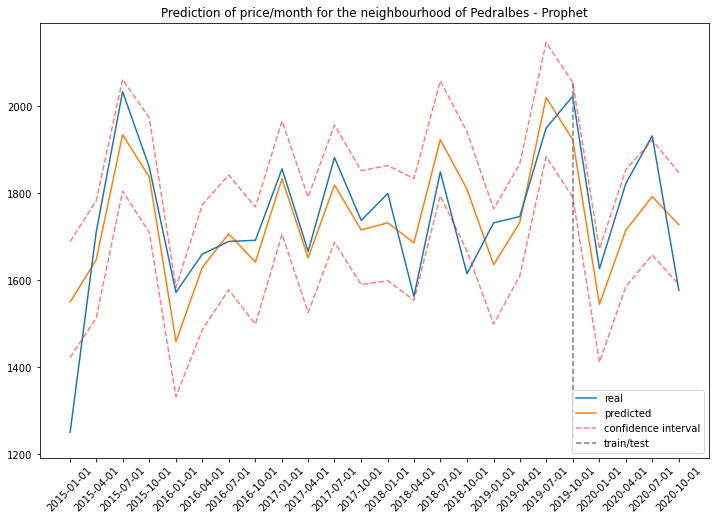

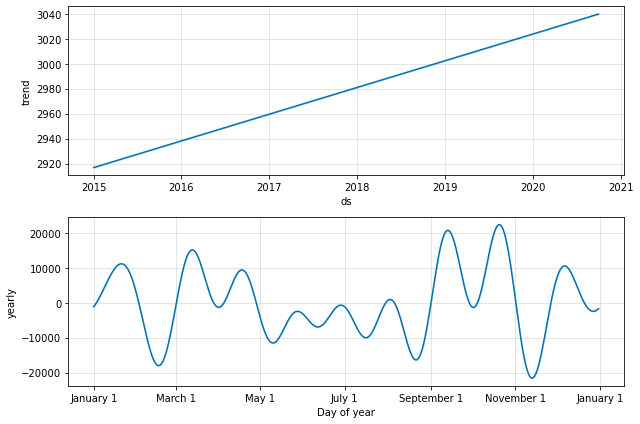

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------

Added regressors:
    -availability_365
    -more than 2 foreigners


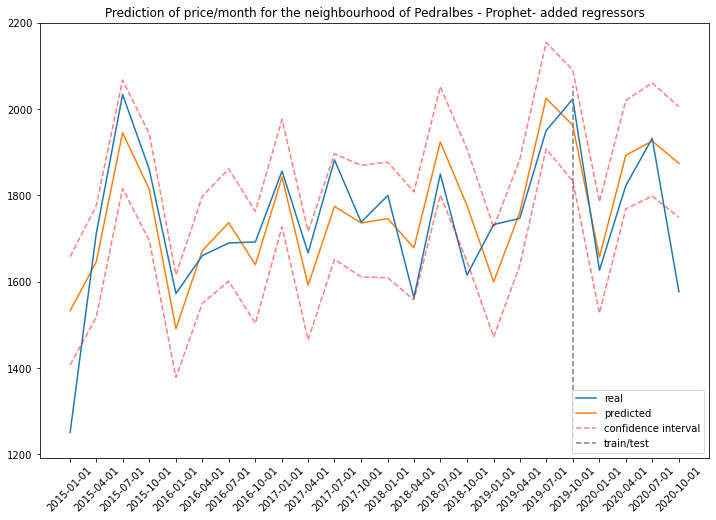

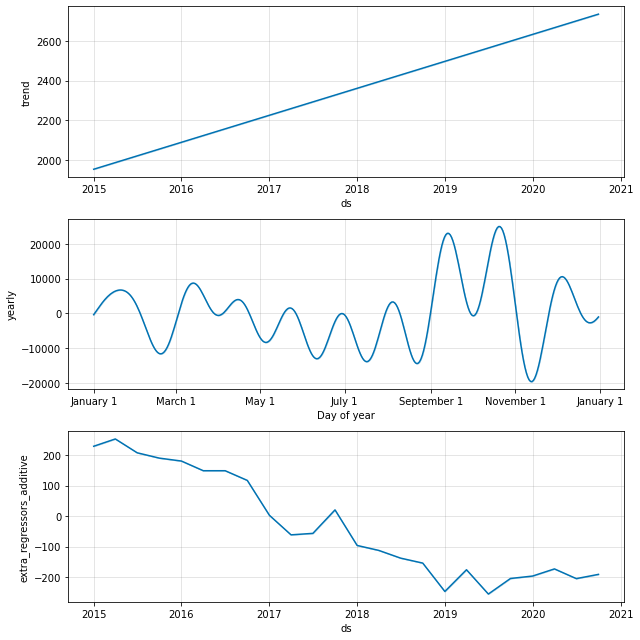

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------

Added regressors:


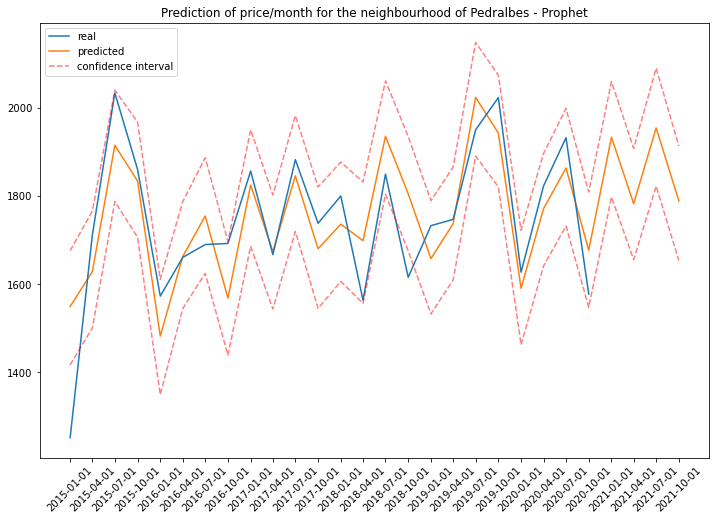

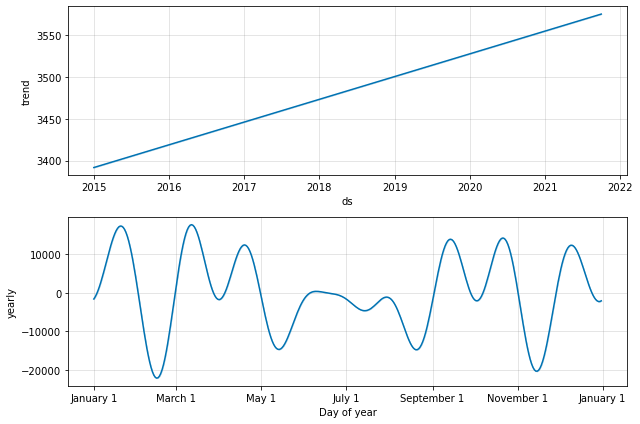

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

ERROR: nprophet - _lr_range_test: Failed to compute the gradients, there might not be enough points.
ERROR:nprophet:Failed to compute the gradients, there might not be enough points.
ERROR: nprophet - _lr_range_test: lr range test failed. defaulting to lr: 0.1
ERROR:nprophet:lr range test failed. defaulting to lr: 0.1
Epoch[14/800]:   1%|▏         | 10/800 [00:00<00:08, 97.25it/s, SmoothL1Loss=0.0672, MAE=325, RegLoss=0]


------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------

Added regressors:


Epoch[800/800]: 100%|██████████| 800/800 [00:08<00:00, 96.76it/s, SmoothL1Loss=0.00348, MAE=68.1, RegLoss=0] 


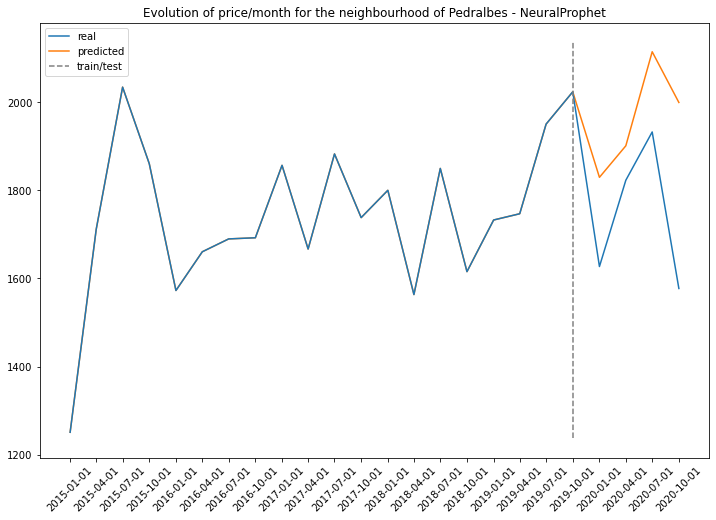

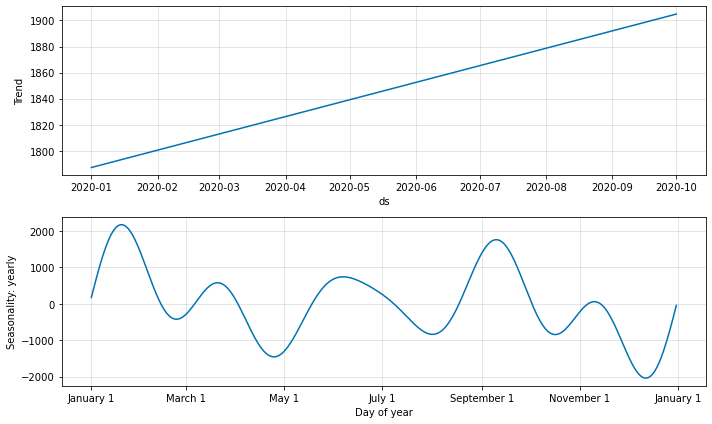

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[5/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.229, MAE=569, RegLoss=0]    


------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------

Added regressors:
    -availability_365
    -more than 2 foreigners


Epoch[800/800]: 100%|██████████| 800/800 [00:09<00:00, 88.41it/s, SmoothL1Loss=0.00351, MAE=68.7, RegLoss=0]


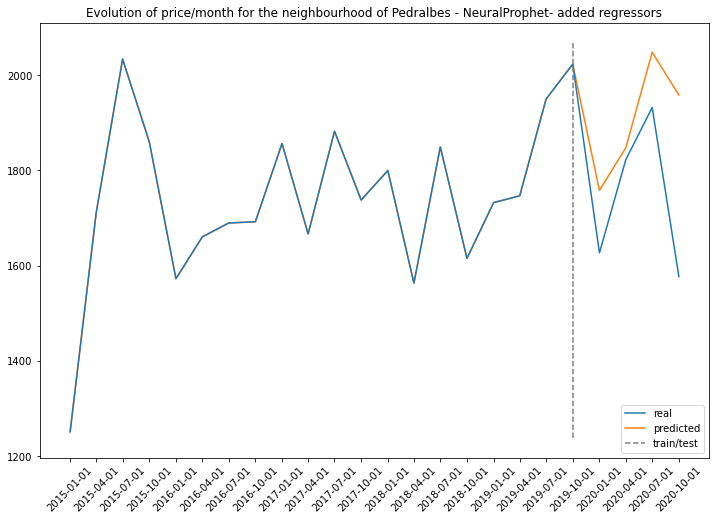

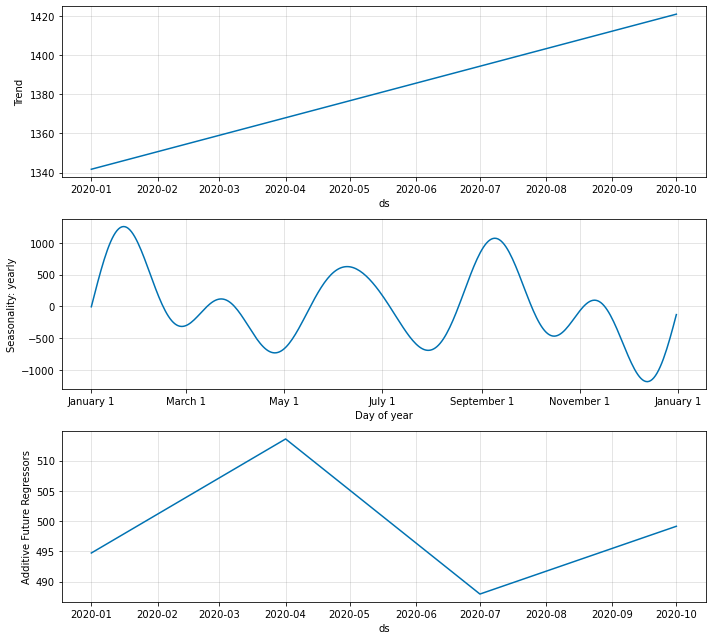

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 666
INFO:nprophet.config:Auto-set epochs to 666


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-02
INFO:nprophet:learning rate range test found optimal lr: 1.52E-02
Epoch[7/666]:   0%|          | 0/666 [00:00<?, ?it/s, SmoothL1Loss=0.643, MAE=830, RegLoss=0]


------- Predicting forecast for rental prices for the Pedralbes neighbourhood -------

Added regressors:


Epoch[666/666]: 100%|██████████| 666/666 [00:08<00:00, 83.08it/s, SmoothL1Loss=0.00707, MAE=87.1, RegLoss=0]


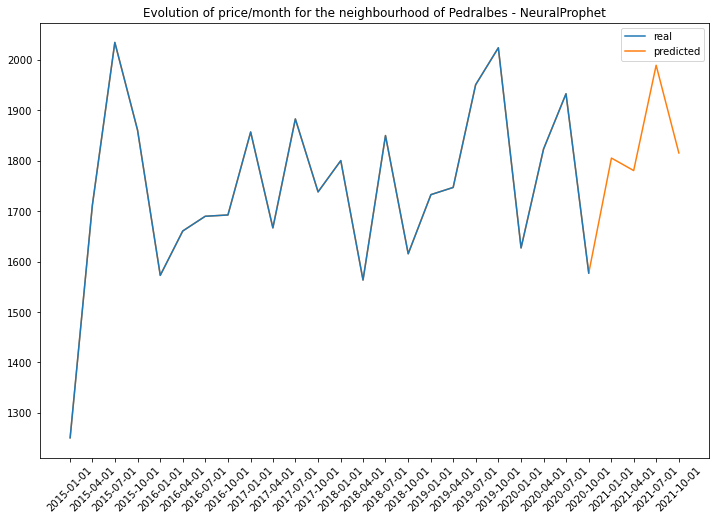

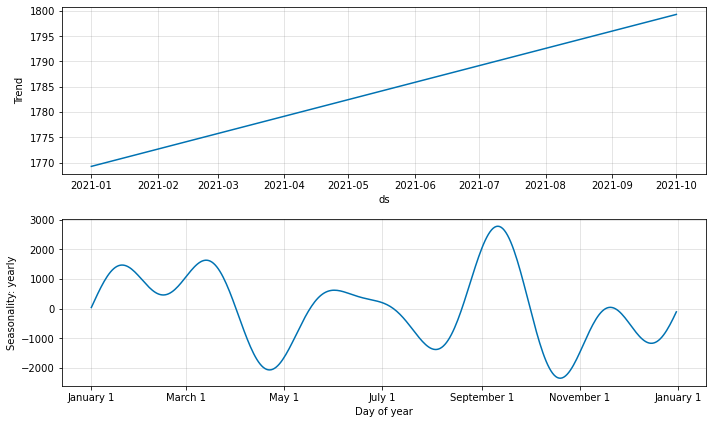


Mean Square Error - prophet - Pedralbes: 122.86
Mean Square Error - prophet with added regressors - Pedralbes: 153.48
Mean Square Error - neural prophet - Pedralbes: 254.17
Mean Square Error - neural prophet with added regressors - Pedralbes: 210.22


In [14]:
n_features = 2
test_size = 0.15
## prophet, just time series
forecast_pedralbes = predict_rent_prophet('Pedralbes', n_features=0, how='test', test_size=test_size, model_type='prophet', scale=False)
## prophet with added regressors
forecast_regr_pedralbes = predict_rent_prophet('Pedralbes', n_features=n_features, how='test', test_size=0.15, model_type='prophet', scale=False) 
## prophet: future (no added regressors)
future_pedralbes = predict_rent_prophet('Pedralbes', how='future', n_periods=4, model_type='prophet', scale=False)
## neural prophet, just time series
forecast_neural_pedralbes = predict_rent_prophet('Pedralbes', how='test', test_size=test_size, n_features=0, model_type='neural_prophet', scale=False) 
## neural prophet with added regressor
forecast_neural_rergr_pedralbes = predict_rent_prophet('Pedralbes', how='test', test_size=test_size, n_features=n_features, model_type='neural_prophet', scale=False)
## neural prophet: future
future_neural_pedralbes = predict_rent_prophet('Pedralbes', how='future', n_periods=4, model_type='neural_prophet', scale=False) ## future

from sklearn.metrics import mean_squared_error

y_true = df[df['neighbourhood_name'] == 'Pedralbes']['y']

n_test_rows = int(np.ceil(y_true.shape[0] * test_size))

y_true = y_true[-n_test_rows:]

y_pred = forecast_pedralbes['yhat'][-n_test_rows:]
forecast_pedralbes_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_regr_pedralbes['yhat'][-n_test_rows:]
forecast_regr_pedralbes_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_pedralbes['yhat1'][-n_test_rows:]
forecast_neural_pedralbes_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_rergr_pedralbes['yhat1'][-n_test_rows:]
forecast_neural_regr_pedralbes_mse = mean_squared_error(y_true, y_pred, squared=False)

print(f'\nMean Square Error - prophet - Pedralbes: {forecast_pedralbes_mse:.2f}')
print(f'Mean Square Error - prophet with added regressors - Pedralbes: {forecast_regr_pedralbes_mse:.2f}')
print(f'Mean Square Error - neural prophet - Pedralbes: {forecast_neural_pedralbes_mse:.2f}')
print(f'Mean Square Error - neural prophet with added regressors - Pedralbes: {forecast_neural_regr_pedralbes_mse:.2f}')

## La Dreta de L'Eixample

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:


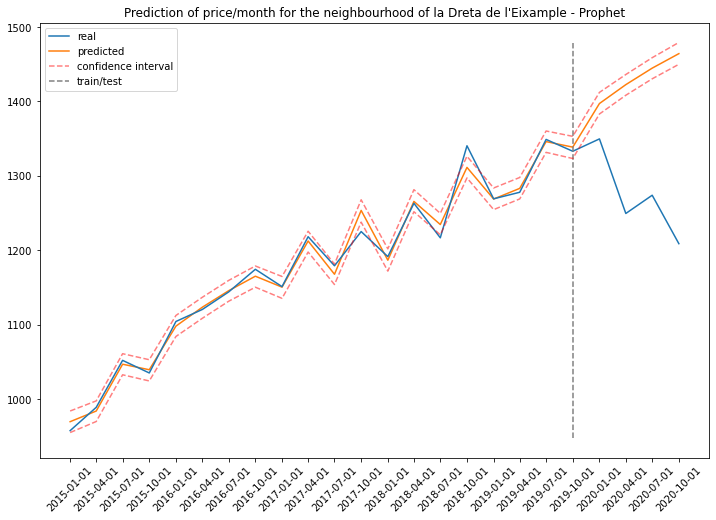

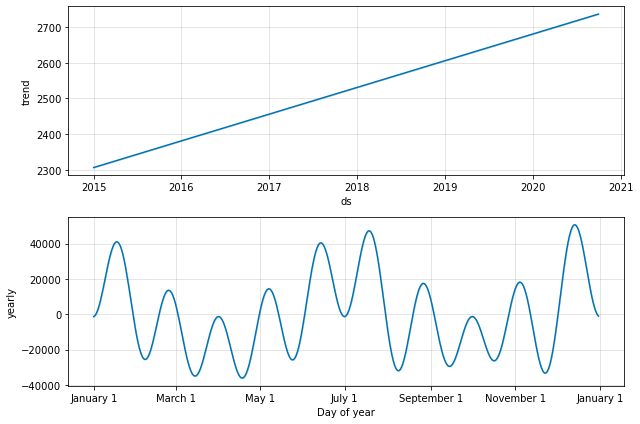

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:
    -n_airbnb_listings
    -1 foreigner
    -long-term unemployment


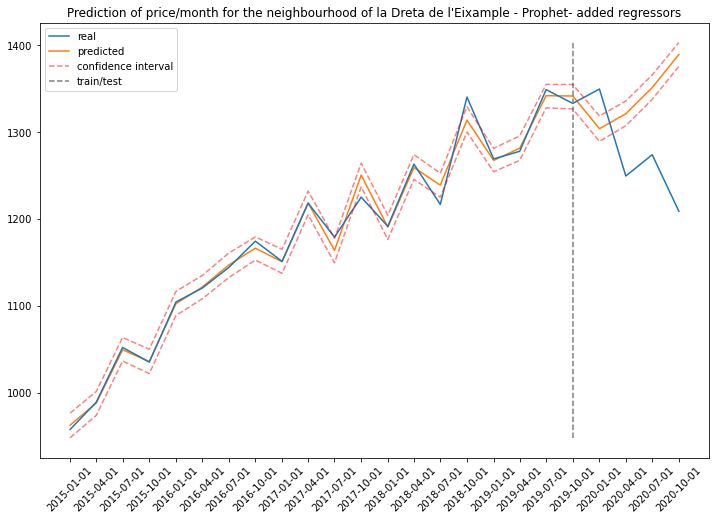

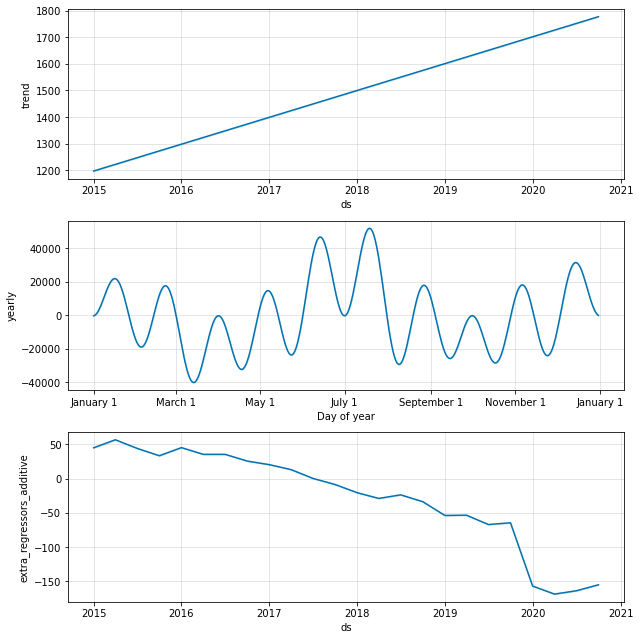

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:


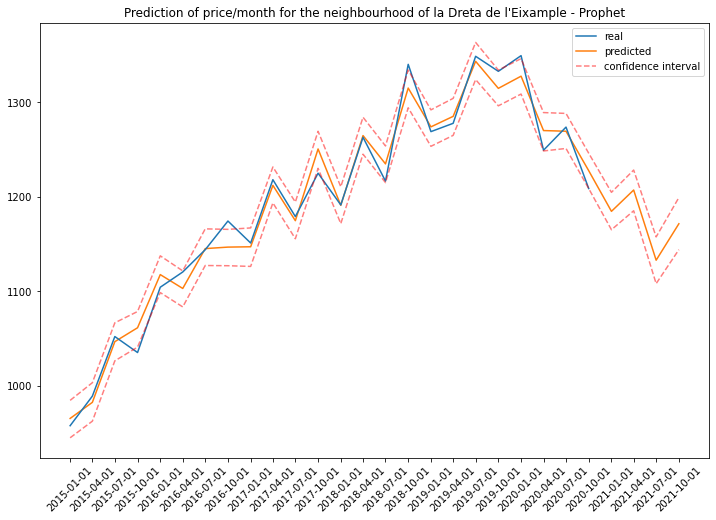

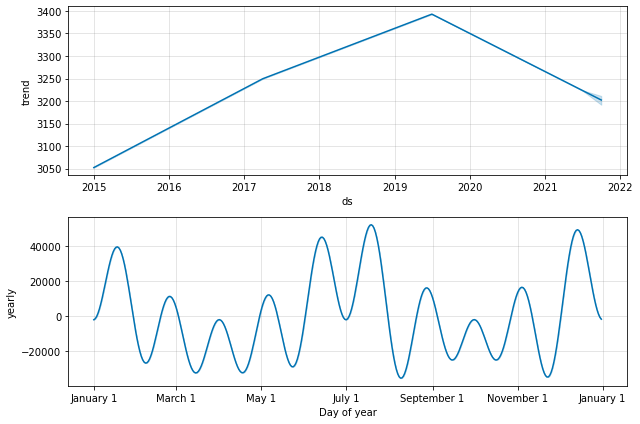

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

ERROR: nprophet - _lr_range_test: Failed to compute the gradients, there might not be enough points.
ERROR:nprophet:Failed to compute the gradients, there might not be enough points.
ERROR: nprophet - _lr_range_test: lr range test failed. defaulting to lr: 0.1
ERROR:nprophet:lr range test failed. defaulting to lr: 0.1
Epoch[14/800]:   1%|▏         | 10/800 [00:00<00:08, 96.43it/s, SmoothL1Loss=0.26, MAE=289, RegLoss=0] 


------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:


Epoch[800/800]: 100%|██████████| 800/800 [00:08<00:00, 95.25it/s, SmoothL1Loss=0.000951, MAE=16.6, RegLoss=0]


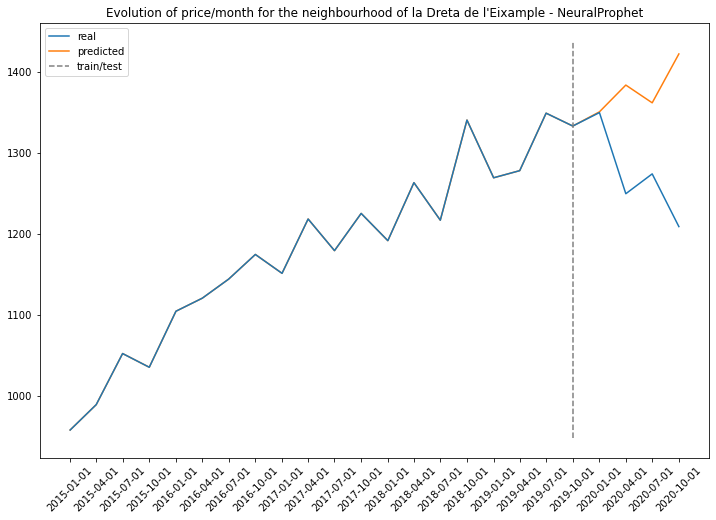

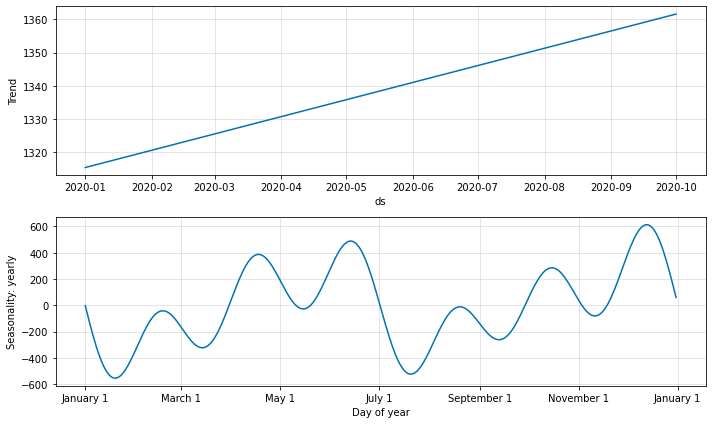

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[5/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.193, MAE=212, RegLoss=0]


------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:
    -n_airbnb_listings
    -1 foreigner
    -long-term unemployment


Epoch[800/800]: 100%|██████████| 800/800 [00:09<00:00, 83.59it/s, SmoothL1Loss=0.000845, MAE=15.3, RegLoss=0]


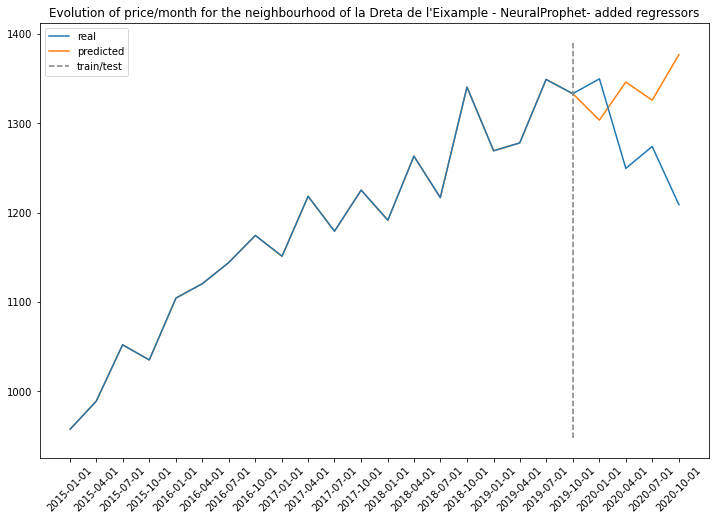

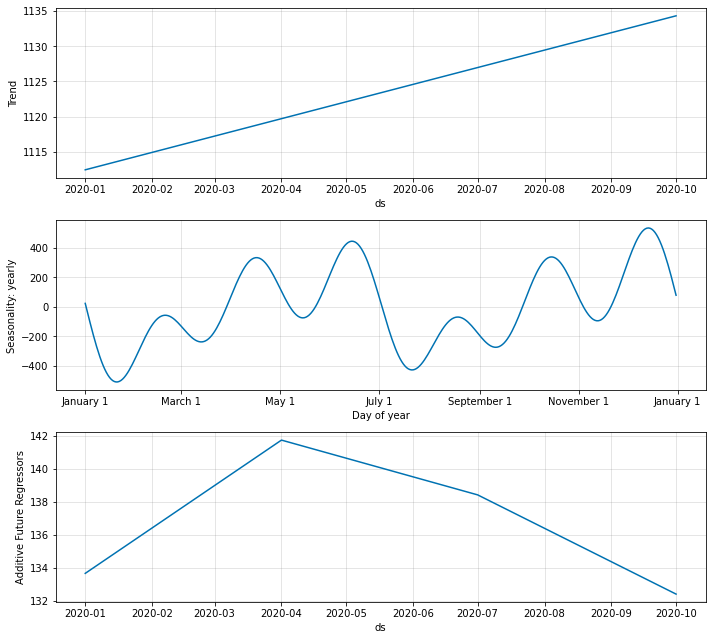

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 666
INFO:nprophet.config:Auto-set epochs to 666


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[6/666]:   0%|          | 0/666 [00:00<?, ?it/s, SmoothL1Loss=0.373, MAE=319, RegLoss=0]


------- Predicting forecast for rental prices for the la Dreta de l'Eixample neighbourhood -------

Added regressors:


Epoch[666/666]: 100%|██████████| 666/666 [00:08<00:00, 81.81it/s, SmoothL1Loss=0.00223, MAE=27.2, RegLoss=0]


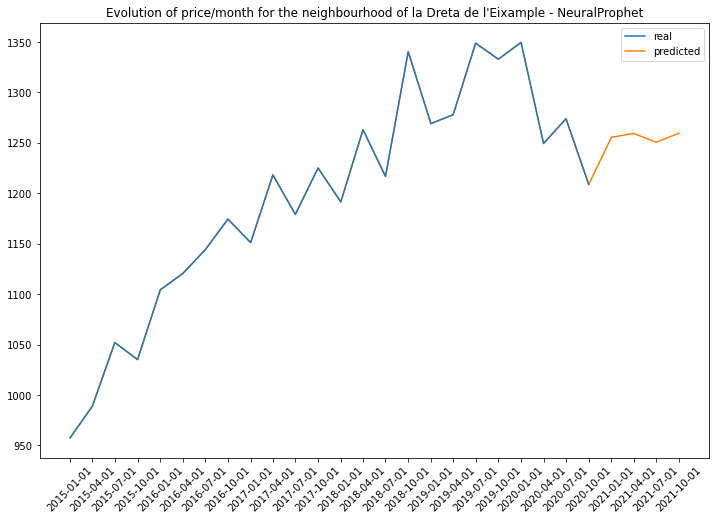

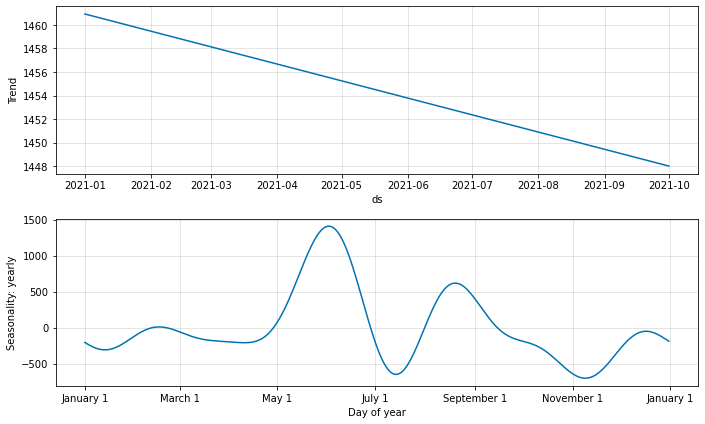


Mean Square Error - prophet - la Dreta de l'Eixample: 177.92
Mean Square Error - prophet with added regressors - la Dreta de l'Eixample: 107.03
Mean Square Error - neural prophet - la Dreta de l'Eixample: 133.41
Mean Square Error - neural prophet with added regressors - la Dreta de l'Eixample: 102.83


In [15]:
n_features = 3
test_size = 0.15
# prophet, just time series
forecast_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", n_features=0, how='test', test_size=test_size, model_type='prophet', scale=False)
# prophet with added regressors
forecast_regr_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", n_features=n_features, how='test', test_size=0.15, model_type='prophet', scale=False)
# prophet: future (no added regressors)
future_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", how='future', n_periods=4, model_type='prophet', scale=False) ## future
# neural prophet, just time series
forecast_neural_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", how='test', test_size=test_size, n_features=0, model_type='neural_prophet', scale=False) ## neural without added regressors
# neural prophet with added regressors
forecast_neural_regr_dreta_eixample = predict_rent_prophet("la Dreta de l'Eixample", how='test', test_size=test_size, n_features=n_features, model_type='neural_prophet', scale=False) ## with added regressors
# neural prophet, future (no added regressors)
future_neural_dreta_eixamples = predict_rent_prophet("la Dreta de l'Eixample", how='future', n_periods=4, model_type='neural_prophet', scale=False) ## future


y_true = df[df['neighbourhood_name'] == "la Dreta de l'Eixample"]['y']

n_test_rows = int(np.ceil(y_true.shape[0] * test_size))

y_true = y_true[-n_test_rows:]

y_pred = forecast_dreta_eixample['yhat'][-n_test_rows:]
forecast_dreta_eixample_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_regr_dreta_eixample['yhat'][-n_test_rows:]
forecast_regr_dreta_eixample_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_dreta_eixample['yhat1'][-n_test_rows:]
forecast_neural_dreta_eixample_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_regr_dreta_eixample['yhat1'][-n_test_rows:]
forecast_neural_regr_dreta_eixample_mse = mean_squared_error(y_true, y_pred, squared=False)

print(f"\nMean Square Error - prophet - la Dreta de l'Eixample: {forecast_dreta_eixample_mse:.2f}")
print(f"Mean Square Error - prophet with added regressors - la Dreta de l'Eixample: {forecast_regr_dreta_eixample_mse:.2f}")
print(f"Mean Square Error - neural prophet - la Dreta de l'Eixample: {forecast_neural_dreta_eixample_mse:.2f}")
print(f"Mean Square Error - neural prophet with added regressors - la Dreta de l'Eixample: {forecast_neural_regr_dreta_eixample_mse:.2f}")

## El Barri Gòtic

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:


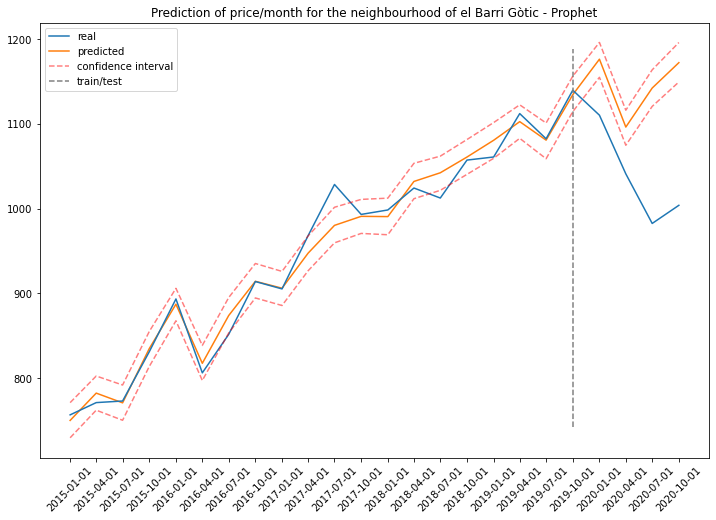

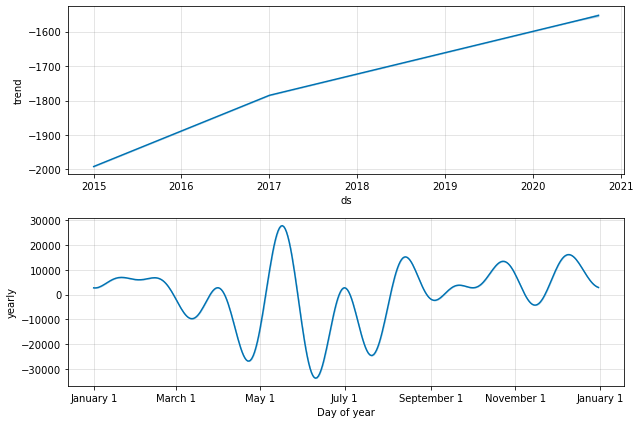

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:
    -more than 2 Spanish
    -availability_365


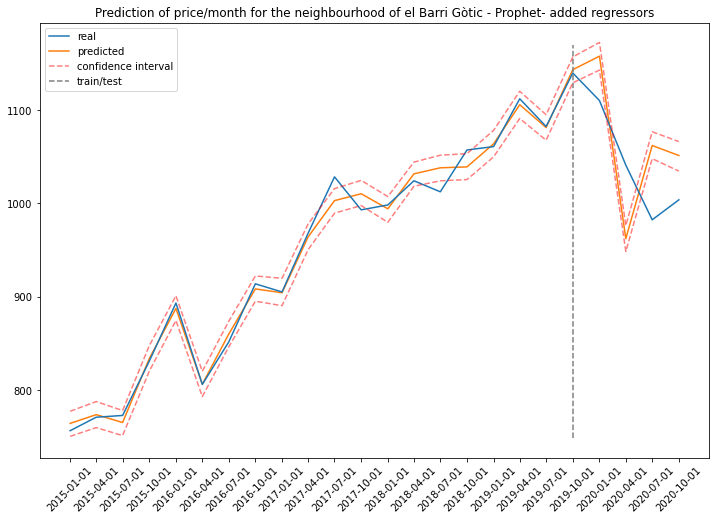

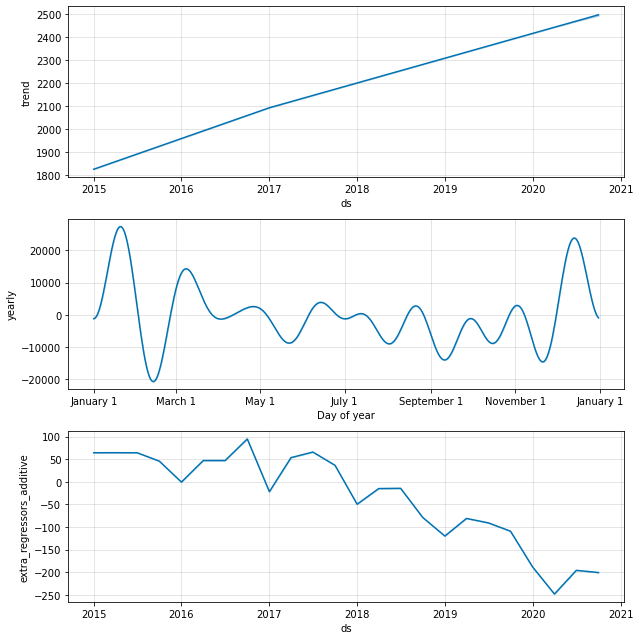

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:


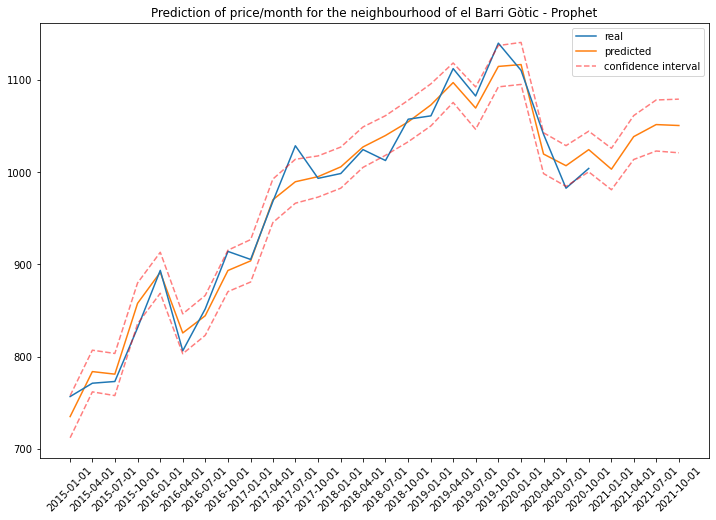

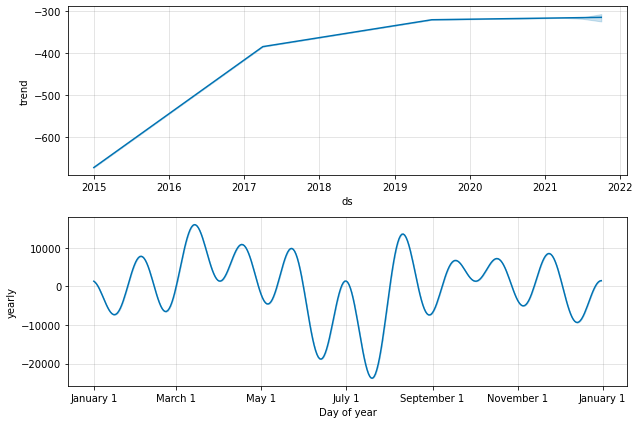

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[7/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.218, MAE=253, RegLoss=0]


------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:


Epoch[800/800]: 100%|██████████| 800/800 [00:08<00:00, 94.19it/s, SmoothL1Loss=0.000556, MAE=12, RegLoss=0]  


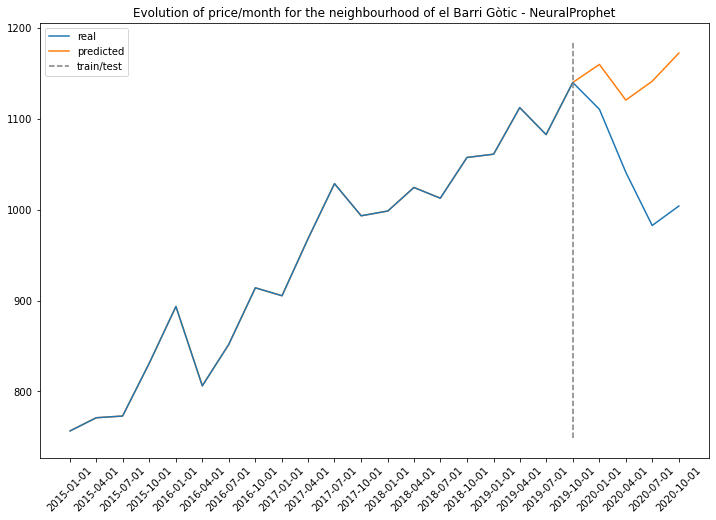

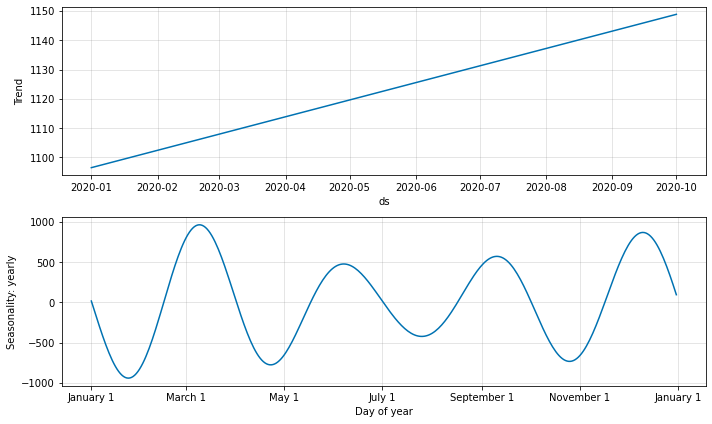

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
INFO:nprophet:learning rate range test found optimal lr: 1.00E-01
Epoch[6/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.758, MAE=519, RegLoss=0]


------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:
    -more than 2 Spanish
    -availability_365


Epoch[800/800]: 100%|██████████| 800/800 [00:09<00:00, 85.85it/s, SmoothL1Loss=0.00042, MAE=10.2, RegLoss=0] 


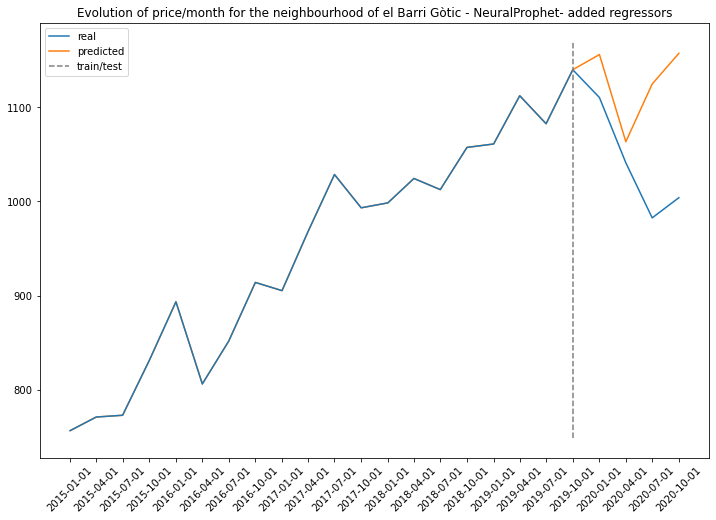

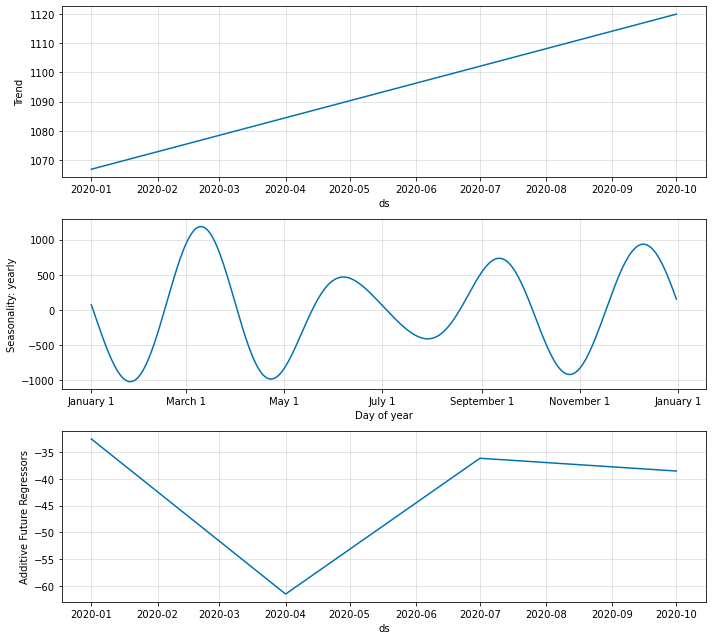

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 666
INFO:nprophet.config:Auto-set epochs to 666


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/666]:   0%|          | 0/666 [00:00<?, ?it/s, SmoothL1Loss=0.475, MAE=386, RegLoss=0]


------- Predicting forecast for rental prices for the el Barri Gòtic neighbourhood -------

Added regressors:


Epoch[666/666]: 100%|██████████| 666/666 [00:08<00:00, 82.62it/s, SmoothL1Loss=0.00117, MAE=17.7, RegLoss=0]


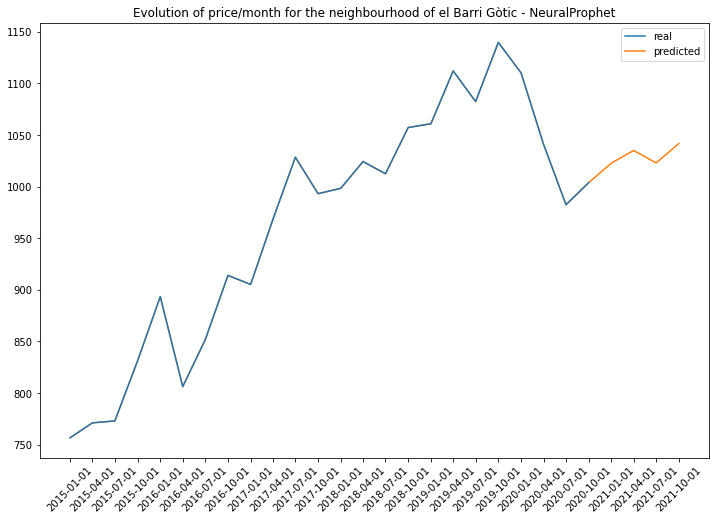

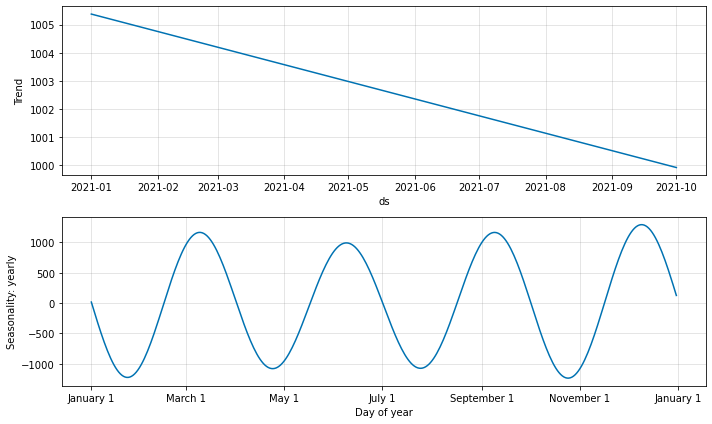


Mean Square Error - prophet - el Barri Gòtic: 123.76
Mean Square Error - prophet with added regressors - el Barri Gòtic: 65.22
Mean Square Error - neural prophet - el Barri Gòtic: 124.63
Mean Square Error - neural prophet with added regressors - el Barri Gòtic: 107.51


In [16]:
n_features = 2
test_size = 0.15
# prophet, just time series
forecast_barri_gotic = predict_rent_prophet('el Barri Gòtic', n_features=0, how='test', test_size=test_size, model_type='prophet', scale=False)
# prophet with added regressors
forecast_regr_barri_gotic = predict_rent_prophet('el Barri Gòtic', n_features=n_features, how='test', test_size=test_size, model_type='prophet', scale=False)
# prophet, future forecast
future_barri_gotic = predict_rent_prophet('el Barri Gòtic', how='future', n_periods=4, model_type='prophet', scale=False) ## future
# neural prophet, just time series
forecast_neural_barri_gotic = predict_rent_prophet('el Barri Gòtic', how='test', test_size=test_size, n_features=0, model_type='neural_prophet', scale=False) ## neural without added regressors
# neural prophet with added regressors
forecast_neural_regr_barri_gotic = predict_rent_prophet('el Barri Gòtic', how='test', test_size=test_size, n_features=n_features, model_type='neural_prophet', scale=False) ## with added regressors
# neural prophet, future forecast
future_neural_barri_gotic = predict_rent_prophet('el Barri Gòtic', how='future', n_periods=4, model_type='neural_prophet', scale=False) ## future

y_true = df[df['neighbourhood_name'] == 'el Barri Gòtic']['y']

n_test_rows = int(np.ceil(y_true.shape[0] * test_size))

y_true = y_true[-n_test_rows:]

y_pred = forecast_barri_gotic['yhat'][-n_test_rows:]
forecast_barri_gotic_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_regr_barri_gotic['yhat'][-n_test_rows:]
forecast_regr_barri_gotic_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_barri_gotic['yhat1'][-n_test_rows:]
forecast_neural_barri_gotic_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_regr_barri_gotic['yhat1'][-n_test_rows:]
forecast_neural_regr_barri_gotic_mse = mean_squared_error(y_true, y_pred, squared=False)

print(f"\nMean Square Error - prophet - el Barri Gòtic: {forecast_barri_gotic_mse:.2f}")
print(f"Mean Square Error - prophet with added regressors - el Barri Gòtic: {forecast_regr_barri_gotic_mse:.2f}")
print(f"Mean Square Error - neural prophet - el Barri Gòtic: {forecast_neural_barri_gotic_mse:.2f}")
print(f"Mean Square Error - neural prophet with added regressors - el Barri Gòtic: {forecast_neural_regr_barri_gotic_mse:.2f}")

## La Sagrada Família

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:


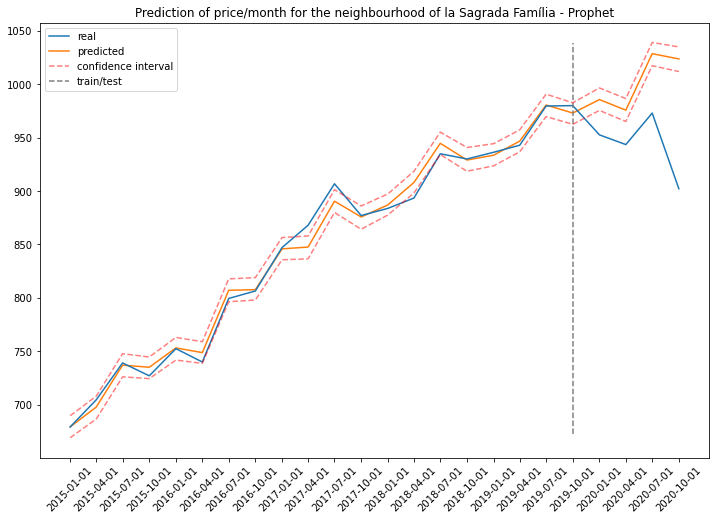

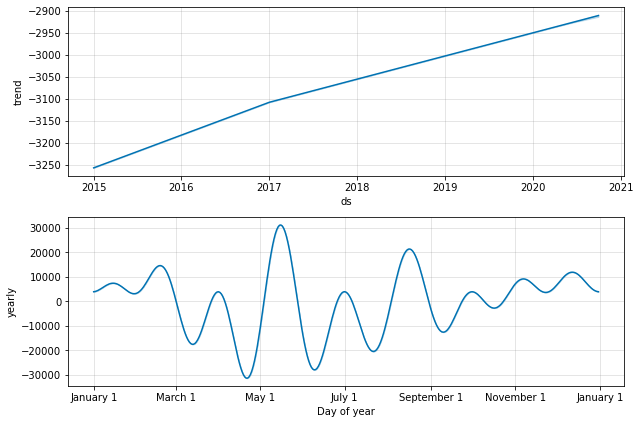

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:
    -n_airbnb_listings
    -availability_365


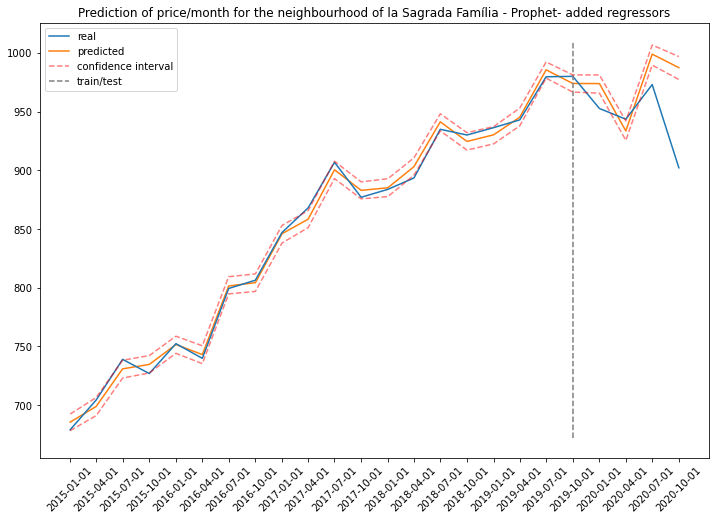

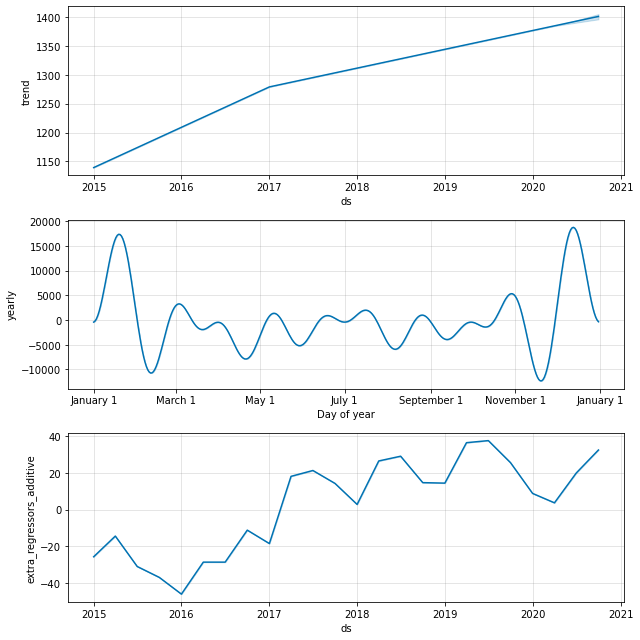

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:


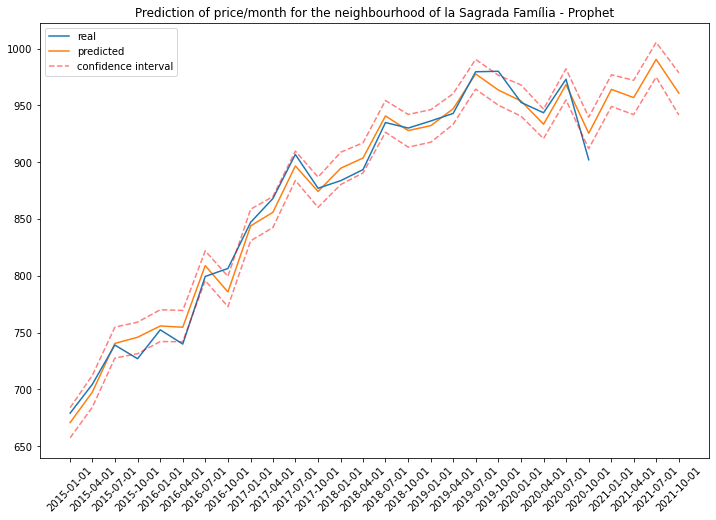

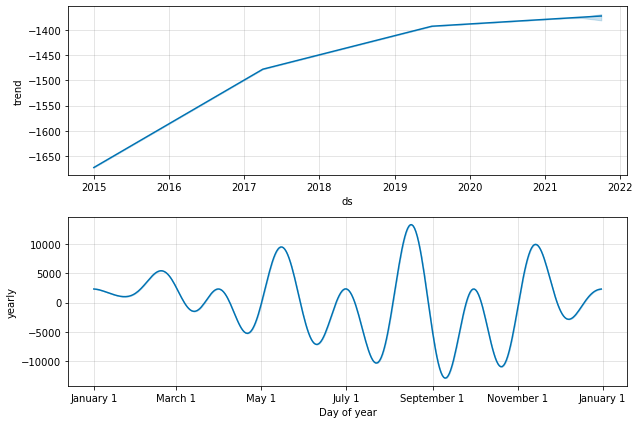

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-05
INFO:nprophet:learning rate range test found optimal lr: 1.87E-05
Epoch[8/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.305, MAE=259, RegLoss=0]


------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:


Epoch[800/800]: 100%|██████████| 800/800 [00:08<00:00, 95.10it/s, SmoothL1Loss=0.222, MAE=215, RegLoss=0]


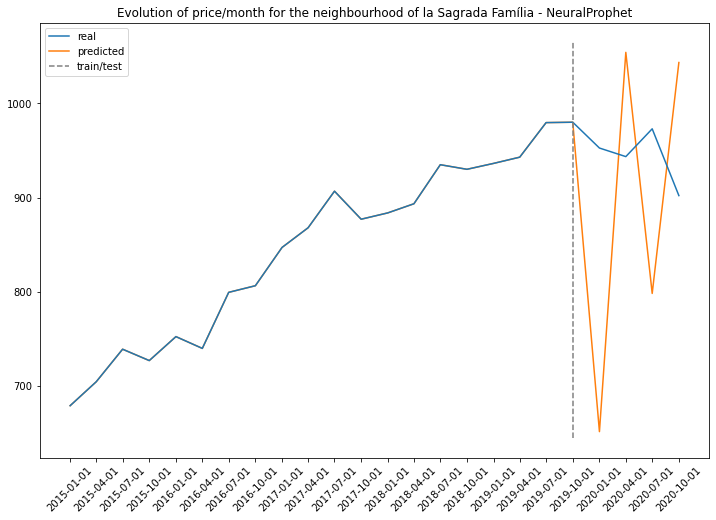

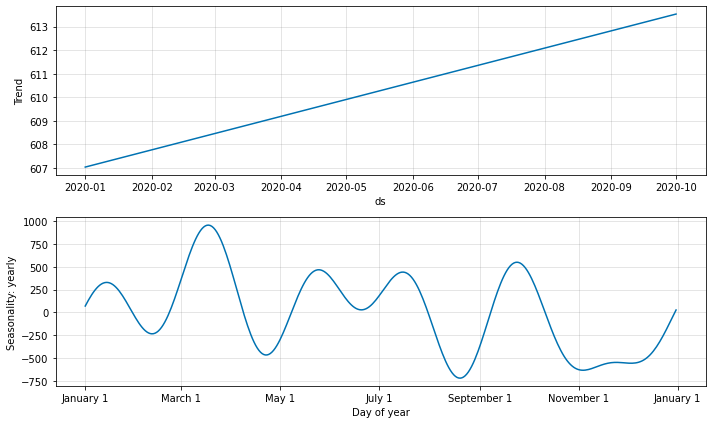

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
INFO:nprophet:learning rate range test found optimal lr: 1.00E-01
Epoch[5/800]:   0%|          | 0/800 [00:00<?, ?it/s, SmoothL1Loss=0.83, MAE=469, RegLoss=0] 


------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:
    -n_airbnb_listings
    -availability_365


Epoch[800/800]: 100%|██████████| 800/800 [00:09<00:00, 85.36it/s, SmoothL1Loss=9.31e-5, MAE=4.35, RegLoss=0] 


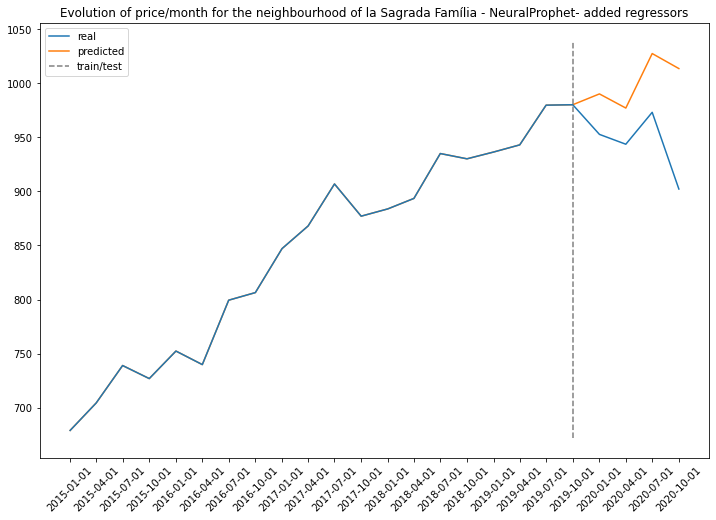

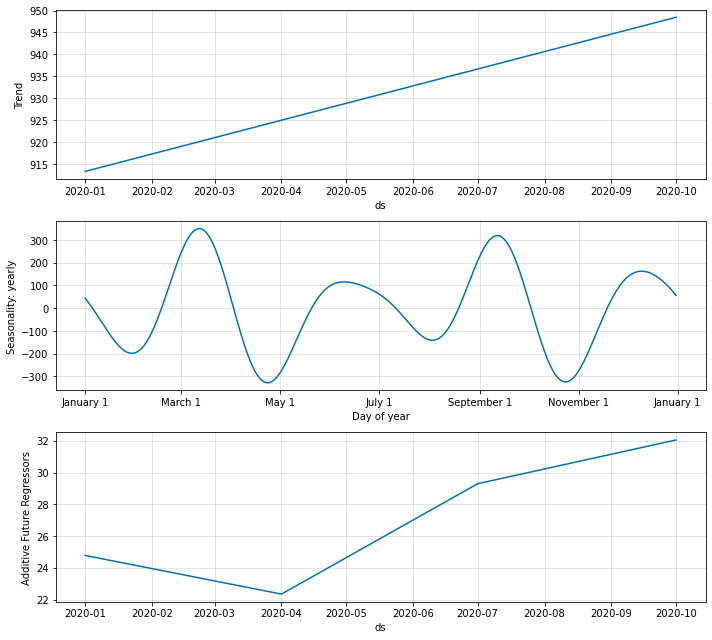

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 666
INFO:nprophet.config:Auto-set epochs to 666


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-02
INFO:nprophet:learning rate range test found optimal lr: 6.58E-02
Epoch[4/666]:   0%|          | 0/666 [00:00<?, ?it/s, SmoothL1Loss=0.816, MAE=439, RegLoss=0]


------- Predicting forecast for rental prices for the la Sagrada Família neighbourhood -------

Added regressors:


Epoch[666/666]: 100%|██████████| 666/666 [00:08<00:00, 81.48it/s, SmoothL1Loss=0.000263, MAE=6.18, RegLoss=0]


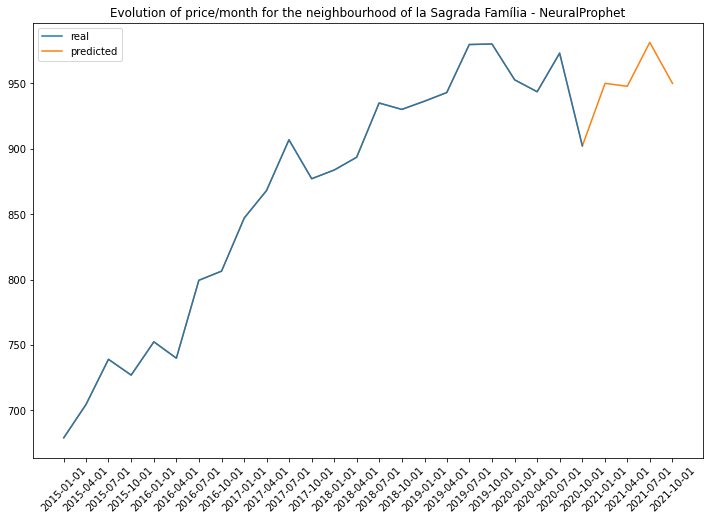

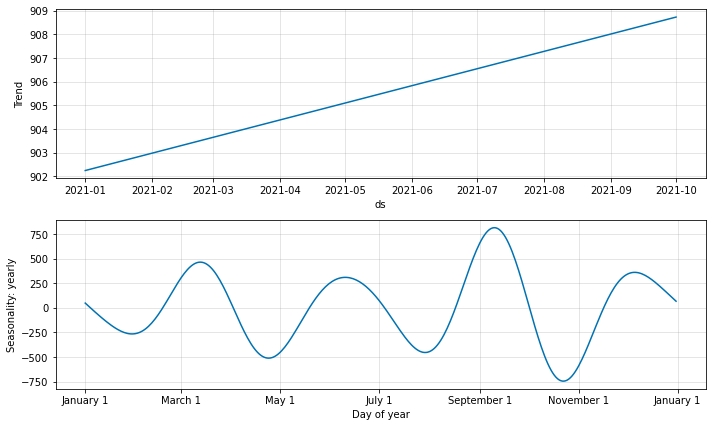


Mean Square Error - prophet - la Sagrada Família: 70.74
Mean Square Error - prophet with added regressors - la Sagrada Família: 46.08
Mean Square Error - neural prophet - la Sagrada Família: 195.85
Mean Square Error - neural prophet with added regressors - la Sagrada Família: 66.82


In [17]:
n_features = 2
test_size = 0.15
forecast_sagrada_familia = predict_rent_prophet('la Sagrada Família', n_features=0, how='test', test_size=test_size, model_type='prophet', scale=False)
forecast_regr_sagrada_familia = predict_rent_prophet('la Sagrada Família', n_features=n_features, how='test', test_size=test_size, model_type='prophet', scale=False)
future_sagrada_familia = predict_rent_prophet('la Sagrada Família', how='future', n_periods=4, model_type='prophet', scale=False) ## future
forecast_neural_sagrada_familia = predict_rent_prophet('la Sagrada Família', how='test', test_size=test_size, n_features=0, model_type='neural_prophet', scale=False) ## neural without added regressors
forecast_neural_regr_sagrada_familia = predict_rent_prophet('la Sagrada Família', how='test', test_size=test_size, n_features=n_features, model_type='neural_prophet', scale=False) ## with added regressors
future_neural_sagrada_familia = predict_rent_prophet('la Sagrada Família', how='future', n_periods=4, model_type='neural_prophet', scale=False) ## future

y_true = df[df['neighbourhood_name'] == 'la Sagrada Família']['y']

n_test_rows = int(np.ceil(y_true.shape[0] * test_size))

y_true = y_true[-n_test_rows:]

y_pred = forecast_sagrada_familia['yhat'][-n_test_rows:]
forecast_sagrada_familia_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_regr_sagrada_familia['yhat'][-n_test_rows:]
forecast_regr_sagrada_familia_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_sagrada_familia['yhat1'][-n_test_rows:]
forecast_neural_sagrada_familia_mse = mean_squared_error(y_true, y_pred, squared=False)

y_pred = forecast_neural_regr_sagrada_familia['yhat1'][-n_test_rows:]
forecast_neural_regr_sagrada_familia_mse = mean_squared_error(y_true, y_pred, squared=False)

print(f"\nMean Square Error - prophet - la Sagrada Família: {forecast_sagrada_familia_mse:.2f}")
print(f"Mean Square Error - prophet with added regressors - la Sagrada Família: {forecast_regr_sagrada_familia_mse:.2f}")
print(f"Mean Square Error - neural prophet - la Sagrada Família: {forecast_neural_sagrada_familia_mse:.2f}")
print(f"Mean Square Error - neural prophet with added regressors - la Sagrada Família: {forecast_neural_regr_sagrada_familia_mse:.2f}")

In [18]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 888
INFO:nprophet.config:Auto-set epochs to 888


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-02
INFO:nprophet:learning rate range test found optimal lr: 4.33E-02
Epoch[888/888]: 100%|██████████| 888/888 [00:09<00:00, 90.76it/s, SmoothL1Loss=0.00744, MAE=80.9, RegLoss=0]


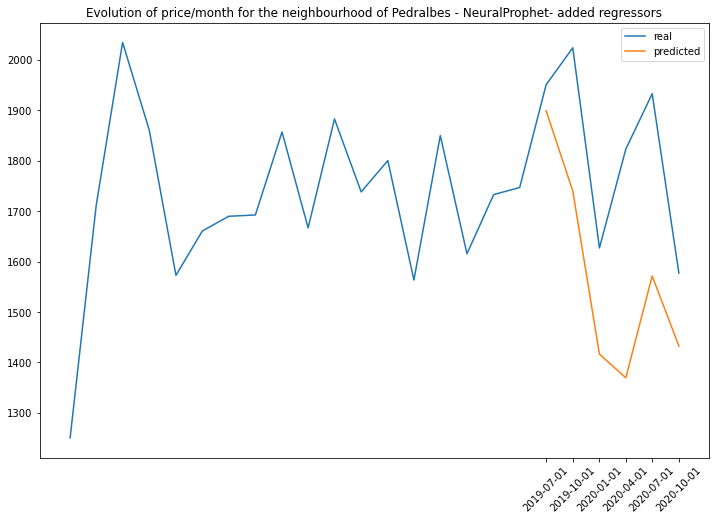

,ds,y,yhat1,residual1,trend,season_yearly,future_regressors_additive,future_regressor_bachelors degree,future_regressor_more than 2 foreigners
0,2019-07-01,None,1898.629639,NaN,900.979370,323.314056,674.336243,-111.843109,786.179382
1,2019-10-01,None,1739.767334,NaN,862.391357,203.039719,674.336243,-111.843109,786.179382
2,2020-01-01,None,1416.422363,NaN,823.803223,-32.025738,624.644897,-105.307106,729.951965
3,2020-04-01,None,1369.649658,NaN,785.634521,-40.629845,624.644897,-105.307106,729.951965
4,2020-07-01,None,1571.439575,NaN,747.466003,199.328720,624.644897,-105.307106,729.951965
5,2020-10-01,None,1432.610596,NaN,708.877930,99.087814,624.644897,-105.307106,729.951965


In [19]:
neighbourhood_name = 'Pedralbes'

df_neighb = df[df['neighbourhood_name'] == neighbourhood_name]
df_train, df_test, df_train, df_test =timeseries_train_test_split(df_neighb, df_neighb, test_size=0.25)

model = NeuralProphet(n_changepoints=2)
# list of features, by order of correlation
features = most_corr_features(df_neighb.drop(['year', 'neighbourhood_code', 'neighbourhood_name',
                                                  'price_m2_month(€)', 'district_code', 'district_name'], axis=1))
# future regressors
n_features = 2

# add future regressor again to the dataframe
df_train = df_train[['ds', 'y'] + features[:n_features]]
# tell the model to add the future regressors
model =model.add_future_regressor(name=features[0])
model = model.add_future_regressor(name=features[1])

metrics = model.fit(df_train, freq='QS')

future_regressors_df = df_test[features[:n_features]]

n_periods = df_test.shape[0]
future = model.make_future_dataframe(df_train, regressors_df=future_regressors_df, periods=n_periods)

forecast = model.predict(future)

plot_prediction_prophet(neighbourhood_name, df_neighb, forecast, features, model_type='neural_prophet')
    
forecast